In [ ]:
import sys
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(6,6)
plt.rcParams['font.weight']='bold'
plt.rcParams['axes.labelweight']='bold'
plt.rcParams['lines.linewidth']=1.5
plt.rcParams['lines.markeredgewidth']=2
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [ ]:
sys.path.append('/Applications/OpenFUSIONToolkit/python')

from OpenFUSIONToolkit import OFT_env
from OpenFUSIONToolkit.TokaMaker import TokaMaker
from OpenFUSIONToolkit.TokaMaker.meshing import load_gs_mesh
from OpenFUSIONToolkit.TokaMaker.util import create_isoflux

In [3]:
myOFT = OFT_env(nthreads=2)
mygs = TokaMaker(myOFT)

#----------------------------------------------
Open FUSION Toolkit Initialized
Development branch:   main
Revision id:          8905cc5
Parallelization Info:
  Not compiled with MPI
  # of OpenMP threads =    2
Fortran input file    = /var/folders/05/5bk04kj15rg64s4vd1hd6r0m0000gn/T/oft_90727/oftpyin
XML input file        = none
Integer Precisions    =    4   8
Float Precisions      =    4   8  10
Complex Precisions    =    4   8
LA backend            = native
#----------------------------------------------



In [4]:
mesh_pts,mesh_lc,mesh_reg,coil_dict,cond_dict = load_gs_mesh('nextstep_mesh.h5')
mygs.setup_mesh(mesh_pts, mesh_lc, mesh_reg)
mygs.setup_regions(cond_dict=cond_dict,coil_dict=coil_dict)
mygs.setup(order=2,F0=1*3)



**** Loading OFT surface mesh

**** Generating surface grid level  1
  Generating boundary domain linkage
  Mesh statistics:
    Area         =  5.098E+00
    # of points  =    5677
    # of edges   =   16908
    # of cells   =   11232
    # of boundary points =     120
    # of boundary edges  =     120
    # of boundary cells  =     120
  Resolution statistics:
    hmin =  3.000E-03
    hrms =  3.455E-02
    hmax =  1.152E-01
  Surface grounded at vertex    1537


**** Creating Lagrange FE space
  Order  =    2
  Minlev =   -1

 Computing flux BC matrix 
 Inverting real matrix
   Time =    2.5110000000000002E-003


In [5]:
delta = -0.5
fix_xloc = True  #maintains location of x-points when changing triangularity by modifying inner/outer midplane gaps

In [6]:
coil_names = mygs.coil_sets.keys()
print(coil_names)

dict_keys(['CS_1', 'CS_2', 'CS_3', 'PF_1U', 'PF_1L', 'PF_2U', 'PF_2L', 'PF_3U', 'PF_3L', 'PF_4U', 'PF_4L', 'DIV_1U', 'DIV_1L', 'DIV_2U', 'DIV_2L'])


In [7]:
#Constrain CS current
# coil_reg_mat[0,0] = 1
# coil_reg_mat[1,1] = 1
# coil_reg_mat[1,0] = -1
# coil_reg_mat[2,2] = 1
# coil_reg_mat[2,1] = -1

oil_names = mygs.coil_sets.keys()
coil_mirrors = {}
for name in coil_names:
    if 'U' in name:
        coil_mirrors[name] = name.replace('U','L')

regularization_terms = []
for name, coil in mygs.coil_sets.items():
    if name not in coil_mirrors:
        continue
    
    if 'CS' in name:
        regularization_terms.append(mygs.coil_reg_term({name: 1.0}, target=-3E6, weight=5))
        regularization_terms.append(mygs.coil_reg_term({name: 1.0, coil_mirrors[name]: -1.0}, target=0, weight=5))
    else:
        regularization_terms.append(mygs.coil_reg_term({name: 1.0}, target=0, weight=1))
        regularization_terms.append(mygs.coil_reg_term({name: 1.0, coil_mirrors[name]: -1.0}, target=0.0, weight=1.E1))
    
mygs.set_coil_reg(reg_terms=regularization_terms)

In [8]:
coil_bounds = {key: [-1e11, 1e11] for key in mygs.coil_sets}
for key in [x for x in mygs.coil_sets if 'DIV' in x]:   
    coil_bounds[key] = [0, 0] # turn off div coils, for now
mygs.set_coil_bounds(coil_bounds)

In [9]:
# Define shape of P' anf FF' profiles
n_sample = 40
psi_sample = np.linspace(0.0,1.0,n_sample)
# Set F*F' profile
alpha = 2
gamma = 1.25
ffp_prof = {
    'type': 'linterp',
    'x': psi_sample,
    'y': np.power(1.0-np.power(psi_sample,alpha),gamma)
}
ffp_prof['y'] /= ffp_prof['y'][0] # Normalize profile (not required but convienient)
# Set P' profile
alpha = 2
gamma = 1.25
pp_prof = {
    'type': 'linterp',
    'x': psi_sample,
    'y': np.power(1.0-np.power(psi_sample,alpha),gamma)
}
pp_prof['y'] /= pp_prof['y'][0] # Normalize profile (not required but convienient)

mygs.set_profiles(ffp_prof=ffp_prof,pp_prof=pp_prof)

In [10]:
# set global targets
Ip_target = 0.75E6
mygs.set_targets(Ip = Ip_target, Ip_ratio=1.0)

Text(0.5, 0, 'R [m]')

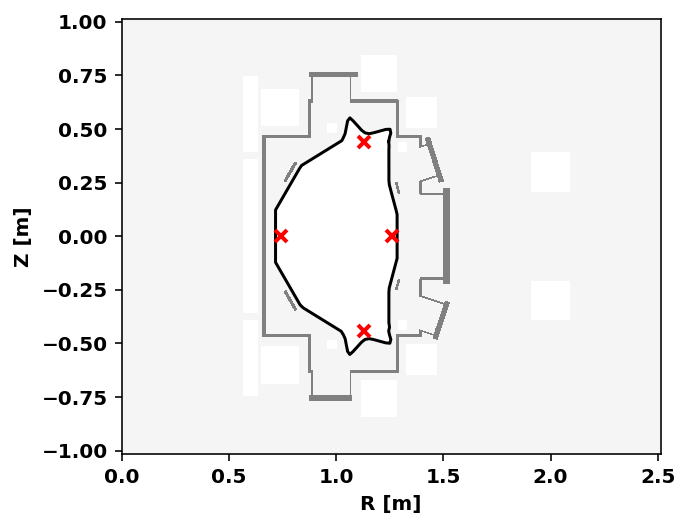

In [11]:
# set boundary/saddle point/strike point targets
if fix_xloc:
    d0 = -0.5
    if delta<d0:
        boundary = create_isoflux(4,1+0.2588*((1-d0)/(1-delta)-1),0.0,0.2588*(1-d0)/(1-delta),1.7*(1-delta)/(1-d0),delta)
    else:
        boundary = create_isoflux(4,1+0.2588*(1-(1+d0)/(1+delta)),0.0,0.2588*(1+d0)/(1+delta),1.7*(1+delta)/(1+d0),delta)
else:
    boundary = create_isoflux(4,1,0.0,0.2588,1.7,delta)

x_points = np.zeros((2,2))
x_points[0,:] = boundary[np.argmin(boundary[:,1]),:]
x_points[1,:] = boundary[np.argmax(boundary[:,1]),:]
x_weights = 50*np.ones(2)
mygs.set_saddles(x_points, x_weights)

strike_ul = [1.06, 0.55]
strike_ur = [1.255, 0.495]

strike_ll = np.copy(strike_ul)
strike_ll[1] = -strike_ul[1]
strike_lr = np.copy(strike_ur)
strike_lr[1] = -strike_ur[1]

isoflux_weights = 500*np.ones(len(boundary))

mygs.set_isoflux(boundary, isoflux_weights)


fig, ax = plt.subplots(1,1)
mygs.plot_machine(fig,ax,coil_colormap='seismic',coil_symmap=True,coil_scale=1.0E-6,coil_clabel=r'$I_{coil}$ [MA]')
ax.plot(boundary[:,0], boundary[:,1], c='r', ls='', marker='x')
ax.set_ylabel('Z [m]')
ax.set_xlabel('R [m]')


In [12]:
mygs.init_psi(0.68,0,0.2,1.8,0.3)
mygs.settings.maxits = 100
mygs.update_settings()
mygs.solve()

Starting non-linear GS solver
     1  7.1702E+00  3.2429E+00  1.3213E-01  1.0512E+00  9.1050E-05 -0.0000E+00
     2  6.5062E+00  3.0312E+00  1.5313E-02  1.0465E+00  1.1698E-04 -0.0000E+00
     3  6.2609E+00  2.9457E+00  2.2320E-03  1.0441E+00  9.4020E-05 -0.0000E+00
     4  6.1701E+00  2.9133E+00  2.5994E-03  1.0430E+00  9.2649E-05 -0.0000E+00
     5  6.1367E+00  2.9012E+00  1.4378E-03  1.0426E+00  9.1412E-05 -0.0000E+00
     6  6.1247E+00  2.8967E+00  6.6363E-04  1.0424E+00  9.0533E-05 -0.0000E+00
     7  6.1206E+00  2.8952E+00  2.8129E-04  1.0423E+00  8.9960E-05 -0.0000E+00
     8  6.1194E+00  2.8946E+00  1.1280E-04  1.0423E+00  8.9622E-05 -0.0000E+00
     9  6.1190E+00  2.8945E+00  4.3223E-05  1.0423E+00  8.9433E-05 -0.0000E+00
    10  6.1189E+00  2.8944E+00  1.5851E-05  1.0423E+00  8.9329E-05 -0.0000E+00
    11  6.1189E+00  2.8944E+00  5.5392E-06  1.0423E+00  8.9273E-05 -0.0000E+00
    12  6.1189E+00  2.8944E+00  1.8246E-06  1.0423E+00  8.9243E-05 -0.0000E+00
    13  6.1189E+00  2.

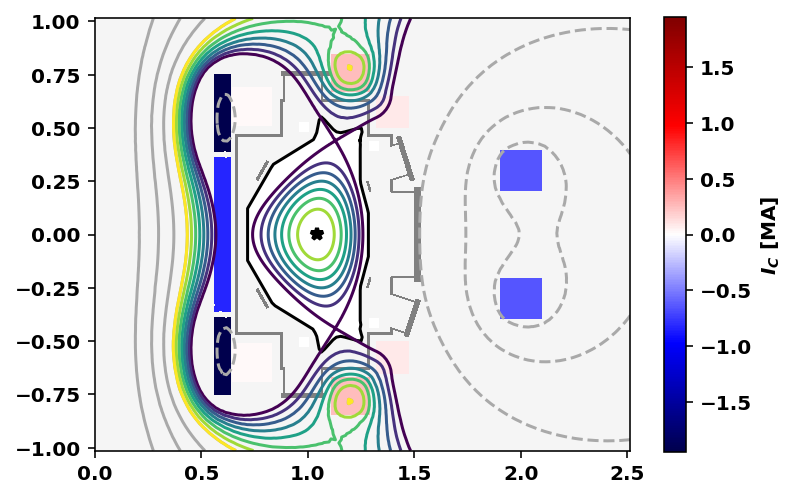

In [13]:
fig, ax = plt.subplots(1,1)
mygs.plot_machine(fig,ax,coil_colormap='seismic',coil_symmap=True,coil_scale=1.E-6,coil_clabel=r'$I_C$ [MA]')
mygs.plot_psi(fig,ax,xpoint_color=None,vacuum_nlevels=4)

In [14]:
mygs.print_info()

Equilibrium Statistics:
  Topology                =   Diverted
  Toroidal Current [A]    =    7.5000E+05
  Current Centroid [m]    =    1.033  0.000
  Magnetic Axis [m]       =    1.042  0.000
  Elongation              =    1.698 (U:  1.707, L:  1.689)
  Triangularity           =   -0.502 (U: -0.511, L: -0.493)
  Plasma Volume [m^3]     =    1.904
  q_0, q_95               =    0.999  2.215
  Plasma Pressure [Pa]    =   Axis:  1.4939E+05, Peak:  1.4939E+05
  Stored Energy [J]       =    1.2371E+05
  <Beta_pol> [%]          =   56.2013
  <Beta_tor> [%]          =    1.2099
  <Beta_n>   [%]          =    1.2525
  Diamagnetic flux [Wb]   =    5.4183E-03
  Toroidal flux [Wb]      =    8.7254E-01
  l_i                     =    1.0205
